 <h1>  <center> <b> Speech Systems (EE6307) </b> </center>

<dt> <h4> <b> Programming Assignment - 01 - Voiced / Unvoiced detection and $F_{0}$ estimation using auto correlation sequence </b> </h4> </dt>

<dt> <h4>  $\underline{\textbf{Objective}}$: Welcome to the first programming assignment (PA) in speech systems (EE6307) course. In this programming assignment, you need to code an algorithm to tag the frames of the given speech signal with voiced, unvoiced and silent labels. Also, write an algorithm to compute the fundamentatal frequency $(F_{0})$ of the voiced frames. In the upcoming programming assignments, more sophisticated voice activity detection and $F_{0}$ estimation methods will be assigned as a task. However, in this PA, we request you to use only the autocorrelation sequence to complete the job. Python modules to record the speech data are included in the notebook. You can either read the speech signals from the drive or record the speech signals using the provided modules for completing the PA. </h4> </dt>

<dt> <h4>  <b> $\underline{\textbf{Instructions}}$: </b> Please follow these instructions </h4> </dt>
<dd> <h4>  1. Plagiarism is strictly prohibited. </h4> </dd>
<dd> <h4>  2. Delayed submissions will be penalized with a scaling factor of 0.5 per day. </h4> </dd>
<dd> <h4>  3. Please DO NOT use any machine learning libraries unless and otherwise specified. </h4> </dd>





<dt> <h4> <b> $\underline{\textbf{Steps}}$: </b> Follow these steps to complete the PA </h4> </dt>
<dt> <h4> 1. Record and load the speech signal. </h4> </dt>
<dt> <h4> 2. Frame the speech signal. </h4> </dt>
<dt> <h4> 3. Voiced / Unvoiced activity detection  </h4> </dt>
<dd> <h4> - Compute the autocorrelation sequence for each frame. </h4> </dd>
<dd> <h4> - Identify the location of the second peak in the autocorrelation sequence. </h4> </dd>
<dd> <h4> - Compare the strength of the second peak with a threshold. If the strength exceeds the threshold, classify the frame as voiced; otherwise, classify it as unvoiced. </h4> </dd>
<dt> <h4> 4. Unvoiced / Silent Classification </h4> </dt>
<dd> <h4> - Compute the energy of frames that are not classified as voiced. </h4> </dd>
<dd> <h4> - If the energy exceeds a certain threshold, classify the frame as unvoiced. Note that the threshold is a hyperparameter that should be optimized empirically. </h4> </dd>
<dd> <h4> - If the energy is below the threshold, classify the frame as silent. </h4> </dd>
<dt> <h4> 5. Estimation of Fundamental Frequency (\(F_{0}\)) </h4> </dt>
<dd> <h4> - Select the frame that has been classified as voiced. </h4> </dd>
<dd> <h4> - Identify the location of the second peak in the autocorrelation sequence. </h4> </dd>
<dd> <h4> - Calculate the fundamental frequency (\(F_{0}\)) by taking the inverse of this location. </h4> </dd>
<dt> <h4> 6. Illustration of PA Outcomes </h4> </dt>
<dd> <h4> - Create a plot with two subplots. </h4> </dd>
<dd> <h4> - In the first subplot, display the time-domain waveform of the speech signal and differentiate the voiced, unvoiced, and silent frames using distinct colors. </h4> </dd>
<dd> <h4> - In the second subplot, display the fundamental frequency of the voiced frames. </h4> </dd>
<dd> <h4>  - You are requested to show the results with the following speech signal.

[link to example speech signal](https://drive.google.com/file/d/1jRrMqrz4NR8x1F6-sbk2I5wSMcti7jD5/view?usp=sharing)

</h4> </dd>

<dt> <h4>  7) Study of submodules in voice activity detection and $F_{0}$ estimation   </h4> </dt>

<dd> <h4> 1. Examine how frame size impacts voice activity detection and fundamental frequency estimation.  </h4> </dd>

<dd> <h4> <dd> <h4> - Try using different frame sizes and observe how they affect the quality of the tags.   </h4> </dd> </h4> </dd>

<dd> <h4> 2. Examine the effects of preprocessing the waveform, such as mean subtraction and max normalization, on the analysis.
 </h4> </dd>

<dd> <h4> 3. Plot and analyze the $F_{0}$ contour for the 'sa-pa-sa' vocals.

[link to 'sa-pa-sa' vocals](https://drive.google.com/file/d/11UkMo8c4qK1gxxtMN2QycooHVyXizK7U/view?usp=sharing)  </h4> </dd>

<dd> <h4> 4. Why the autocorrelation function rolls off with lag? what other methods can be employed to prevent it? </h4> </dd>

<h4>  8) Provide a detailed report of your observations for each experiment. </h4>






<dt> <h4> <b>  1) Speech recording: </b>
This part of the PA includes modules for recording the speech signal in an online mode.  </h4> </dt>


In [1]:
# All imports
from IPython.display import Javascript
from google.colab import output, drive
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment
import soundfile as sf
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import scipy.io.wavfile
import io
import os
from tqdm import tqdm

In [2]:

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

######################## Module for recording the speech signal ########################
#1. The below code records the speech signal for 3 sec ( you can change the duration of the recording in the code ) and store it as 'recording.wav' <br/>
#2. If you have already recorded or uploaded the file named 'recording.wav', the code uses that file. Otherwise, it records and saves the file with the name 'recording.wav.'
#### Please comment below line, if you already uploaded the 'recording.wav' in '/content/'
# !rm recording.wav

if os.path.isfile('recording.wav'):
    print("wavefile exists, later part of the code uses 'recording.wav' as input speech")
    (rate,sig) = scipy.io.wavfile.read("recording.wav")
    print(len(sig))
else:
    print("There is no file in the current directory, please record your voice")
    print("Recording started!")
    wav = record(3.0) #It will record three seconds of your speech
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording.wav', 16000, fp_arr)
    plt.plot(fp_arr)
    plt.show()

wavefile exists, later part of the code uses 'recording.wav' as input speech
124826


In [3]:
######################## Reading speech signal ########################
sig,rate = sf.read("recording.wav")
print(sig.shape)
print(rate)

(124826,)
16000


 <dt> <h4> <b> 2) Frame the speech signal: </b> A figure is included to demonstrate the concept of framing the speech signal. It depicts how the speech signal is divided into multiple frames, each with a size of 400 samples and a frameshift of 160 samples. Complete the "FrameSig" function to replicate this process.

</h4> </dt>

<img src ="https://raw.githubusercontent.com/Sreeakanth/SpeechSystems/main/Framing.png" width = "1853px" height = "991px" >



In [4]:
def FrameSig(input, rate, frameSize=0.025, frameShift=0.010, window='hamming'):

    '''
    Example :- samplingRate =16000, frameSize= 0.025 sec, frameShift = 0.010 sec
    Input  = (1,16000*5) # The size of the 5 second speech signal with 16 kHz sampling rate
    Output = (500,400) # Here 500 is the number of frames and 400 is the number of samples in the frame
    '''

    frames = []
    start_index = 0

    frame_length = rate * frameSize
    number_frame_shift = rate * frameShift


    while start_index < input.shape[0]:

      start = start_index
      end = int(start_index + frame_length)

      frames.append(input[start:end])
      start_index += int(number_frame_shift)


    return frames

    #####################################


number of frames: 781
length of frame: 400


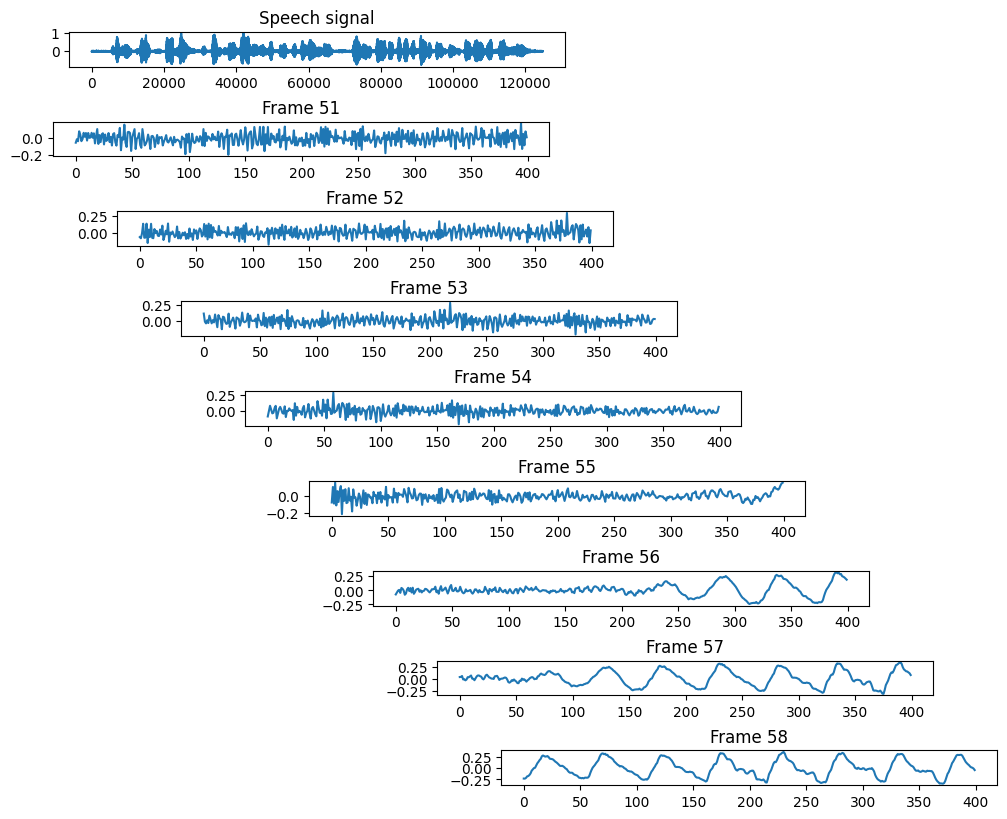

In [5]:
num_frames = 8 #Number of frames of the speech signal to plot

frames = FrameSig(sig, rate)

print(f'number of frames: {len(frames)}')

frame_len = len(frames[0])
print(f'length of frame: {frame_len}')

fig, axs = plt.subplots(num_frames + 1, 1)

# Plot the signal
axs[0].plot(sig)
axs[0].set_title('Speech signal')

prev_x0 = 0 # variable to store x coordinate of previous frame

start_index = 50 # start plotting from frame[start_index]

for i in range(1,num_frames + 1):

  # check for index out of range
  if i-1 + start_index > len(frames):
    continue

  axs[i].plot(frames[i-1 + start_index])
  axs[i].set_title(f'Frame {i + start_index}')

  pos = axs[i].get_position()  # Get the current position of the subplot


  axs[i].set_position([prev_x0 + 0.1, pos.y0 - i*0.1, pos.width, pos.height])

  pos = axs[i].get_position()

  prev_x0 = pos.x0


 <dt> <h4> <b> 3) Voiced / Unvoiced activity detection: </b> Compute the autocorrelation sequence of a mean-subtracted frame $x[n]$ as follows:

<center> $r_{xx}$[k] = $\frac{1}{r_{xx}[0]}\sum_{n=0}^{N}$ x[n]x[n+k]
$\;\;\;\;$ k = ...,-2,-1,0,1,2,... </center>


<dt> <h4> The figure below illustrates the autocorrelation sequence for both voiced and unvoiced frames. It demonstrates that the voiced/unvoiced decision can be made based on the strength of the second peak in the autocorrelation sequence. A frame is classified as voiced if the strength of the second peak exceeds a certain threshold; otherwise, it is classified as unvoiced. For voiced frames, the fundamental frequency ($F_{0}$) period can be determined from the location of this second peak. Note that the threshold is a hyperparameter that must be optimized empirically. Write a code to complete this task. Note that identifying the location of the second peak in the autocorrelation sequence is challenging due to factors such as noise, variations in signal strength, and potential overlapping peaks. To accurately detect the valid second peak, you need to incorporate several constraints in your code, including:
</h4> </dt>

<dt> <h4> 1. Ensure the second peak is distinct and sufficiently higher than neighboring peaks. </h4> </dt>
<dt> <h4> 2. Verify that the second peak occurs at a reasonable distance from the first peak, reflecting typical $F_{0}$. </h4> </dt>
<dt> <h4> 3. Confirm that the peak's position is consistent across different frames to avoid misclassification. </h4> </dt>
<dt> <h4>
Incorporate these meaningful constraints into your code to effectively identify the valid second peak and complete the task.  
</h4> </dt>

<img src ="https://raw.githubusercontent.com/Sreeakanth/SpeechSystems/master/VoicedUnvoiced.png" width = "800px" height = "400px" >



In [6]:
#####################################


def rxx(frame, k):
    """
    Computes the autocorrelation at a given lag k.

    :frame: input frame for which autocorrelation needs to be computed at lag k
    :k: lag
    """

    frame = np.asarray(frame)

    if k < 0:
        k = -k
        frame = frame[::-1]

    # Compute autocorrelation using NumPy's dot product
    if k == 0:
        r_XX = np.dot(frame, frame)
    else:
        r_XX = np.dot(frame[:-k], frame[k:])

    return r_XX

#####################################

#####################################

def AutoCorrelation(frame):
    """
    Takes frame as input and returns auto-correlation sequence of the frame

    :frame:
      frame for which auto-correlation sequence needs to be computed
    """

    k = len(frame) // 2

    shift = np.arange(-k, k+1)

    vectorized_rxx = np.vectorize(lambda k: rxx(frame, k))
    auto_corr = vectorized_rxx(shift)

    return auto_corr/max(auto_corr)


#####################################

#####################################

def get_f0(Rxx, rate):
    """
    Returns the fundamental frequency and location of second peak from the auto-correlation sequence

    :Rxx:
      Auto-correlation sequence of the frame

    :rate:
      Sampling rate of the signal
    """

    second_peak = -1

    start_index = len(Rxx) // 2

    peaks = []

    for k in range(start_index + 30 , len(Rxx)- 30):

      if all(Rxx[k] > Rxx[j] for j in range(k - 30, k)) and all(Rxx[k] > Rxx[j] for j in range(k + 1, k + 31)):

        peaks.append(k)

    peaks = sorted(peaks, key = lambda x: Rxx[x], reverse = True)

    second_peak = -1

    if len(peaks) != 0:

        second_peak = peaks[0]

    if second_peak != -1:

        F0 = rate / (second_peak - start_index)

    else:

        F0 = 0

    return (F0,second_peak)

#####################################

#####################################

def VoicedVSUnvoiced(frame, rate, threshold):
    """
    Given a frame , returns whether the frame is voiced or unvoiced
    If the frame is voiced, The code returns the F0 of the voiced frame
    If the frame is unvoiced. The code returns '0' as F0 ( It will help in filtering out unvoiced frames )

    :frame:
      a fixed window of speech signal

    :rate:
      Sampling rate of the signal

    :threshold:
      threshold above which a signal is classified as voiced else unvoiced
    """

    Rxx = AutoCorrelation(frame)

    F0, second_peak = get_f0(Rxx, rate)

    voiced = 1

    if Rxx[second_peak] < threshold or F0 == 0:

      voiced = 0

    return voiced, F0

#####################################


Fundamental frequency for frame: 228.57142857142858


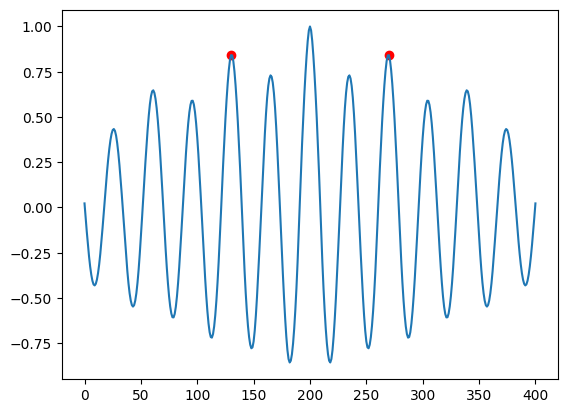

In [7]:
frame_number = 43

frame = frames[frame_number]

Rxx = AutoCorrelation(frame)

F0, idx = get_f0(Rxx, rate)

print(f'Fundamental frequency for frame: {F0}')

if F0!= 0:

  idxs = idx-len(Rxx) //2 -1
  mid = len(Rxx) //2

  for i in range(1,2):

    if mid + i*idxs > len(Rxx) or mid - i*idxs < 0:
      break

    plt.plot(mid + i*idxs+1, Rxx[mid + i*idxs+1], 'ro')
    plt.plot(mid - i*idxs-1, Rxx[mid - i*idxs-1], 'ro')


  plt.plot(Rxx)
  plt.show()

else:

  plt.plot(Rxx)
  plt.show()


<dt> <h4> <b> 4. Unvoiced / Silent Classification: </b> Compute the energy of frames that are not classified as voiced, $E = \sum\limits_{n} | x[n] |^2$. Compare this energy with a threshold. If the energy exceeds a certain threshold, classify the frame as unvoiced. Note that the threshold is a hyperparameter that should be optimized empirically. If the energy is below the threshold, classify the frame as silent. </h4> </dt>


In [8]:
def Energy(frame):
    """
    Returns the energy of the signal

    :frame:
      a fixed window of speech signal
    """
    energy = np.dot(frame, frame)

    return energy

####################

####################

def SilenceVSUnvoiced(unvoiced_frame,threshold):
    """
    Given an unvoiced frame, returns whether the unvoiced frame contains speech information ( fricatives or a few stop consonants etc )  or silence,
    Returns -1 if silent, else returns 0 in case of speech information

    :unvoiced_frame:
      unvoiced frame

    :threshold:
      threshold which is used to classify a frame as unvoiced or silent
    """
    energy = Energy(unvoiced_frame)

    decision = 0

    if energy < threshold:

      decision = -1


    return decision

####################

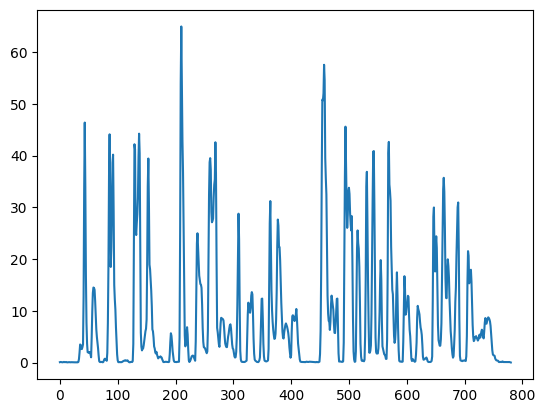

In [9]:
plt.plot(range(len(frames)),[Energy(frames[i]) for i in range(len(frames))])

<dt> <h4> <b> 5. Estimation of Fundamental Frequency (\(F_{0}\)): </b> Use the functions written above to classify the frames of the given speech signal as voiced, unvoiced, or silent. For the frames classified as voiced, identify the location of the second peak in the autocorrelation sequence. Calculate the fundamental frequency $(F_{0})$ by taking the inverse of this location. </h4> </dt>


<dt> <h4> <b> 6. Illustration of PA Outcomes: </b> This part of the PA expects you to tag the speech signal with voiced, unvoiced, and silent labels. And also plot the $F_{0}$ contour ( tracking the $F_{0}$ across the frames ) in the voiced regions. You  can follow these steps to complete this </h4> </dt>
<dd> <h4> - Create a plot with two subplots. </h4> </dd>
<dd> <h4> - In the first subplot, display the time-domain waveform of the speech signal and differentiate the voiced, unvoiced, and silent frames using distinct colors. </h4> </dd>
<dd> <h4> - In the second subplot, display the fundamental frequency of the voiced frames. </h4> </dd>

<dd> <h4>  - You are requested to show the results with the following speech signal.

[link to example speech signal](https://drive.google.com/file/d/1jRrMqrz4NR8x1F6-sbk2I5wSMcti7jD5/view?usp=sharing)

</h4> </dd>





In [10]:
###########################
# Read wavefile ###########
###########################

#Set anyone one of the below falgs as true based on your convenience
read_from_googleDrive = False
read_from_colab = True #Reads recorded wavefile in colab

if read_from_googleDrive:
    #Mount the drive
    drive.mount('/content/drive')
    #wavefile location in drive
    wavefile = '/content/drive/My Drive/example.wav'
    #wavefile reading
    (sig, rate) = sf.read(wavefile)
if read_from_colab:
    #wavefile reading ( By default, the recorded file gets saved as 'recording.wav.' )
    (sig, rate) = sf.read('recording.wav')

###########################
# Chunk the signal into N frames with specific frame size and frameShift and, if required, use a windowing function to reduce the boundary effects.
###########################
frameSize = 0.025
frameShift = 0.010
windowing = 'hamming'
Frames = FrameSig(sig, rate, frameSize, frameShift, windowing)
EnergyThreshold = 5 #set energy threshold for fricative vs silence frame detection from the unvoiced frames
PeakThreshold = 0.5
decision = [0]*len(Frames)
freq = [0]* len(Frames)


for index, Frame in tqdm(enumerate(Frames)):


  VoicedDecision, EstimatedF0=VoicedVSUnvoiced(Frame, rate, PeakThreshold)

  if VoicedDecision == 1:

    decision[index] = 1

    freq[index] = EstimatedF0

  else:

    value = SilenceVSUnvoiced(Frame, EnergyThreshold)

    if value == -1:

      decision[index] = -1

    else:
       decision[index] = 0


781it [00:02, 272.58it/s]


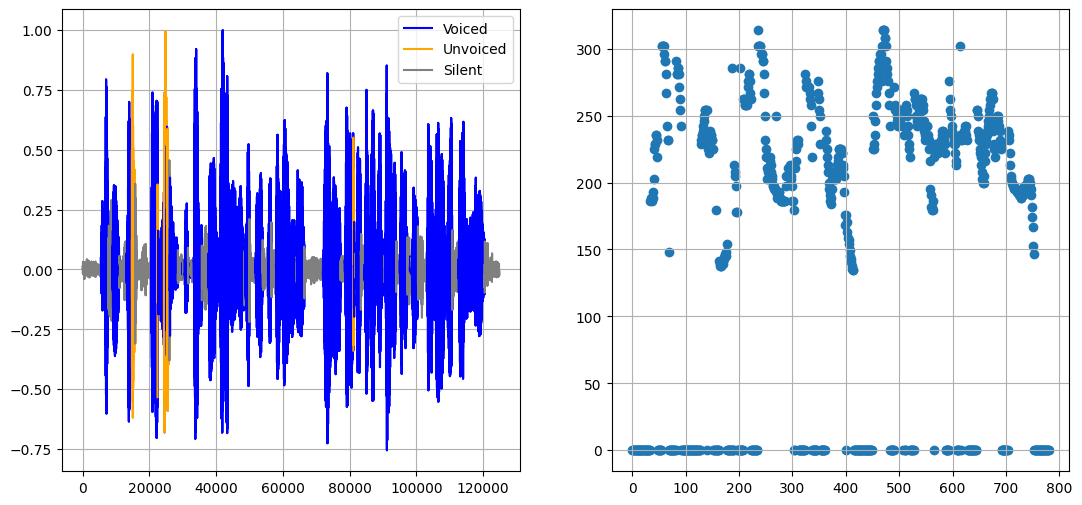

In [11]:
def color(decision):

  if decision == 1:

    return 'blue'

  if decision == 0:

    return 'orange'

  else:

    return 'grey'


frameShift = int(rate * 0.010)
frameSize = int(rate * 0.025)

frame_decision = {}

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

for index, frame in enumerate(Frames):

    if index*frameShift + frameSize >  len(sig):

      axes[0].plot(range(index*frameShift, len(sig)), sig[index*frameShift:], color = color(decision[index]))
      continue

    axes[0].plot(range(index*frameShift, index*frameShift + frameSize), sig[index*frameShift: index*frameShift + frameSize], color = color(decision[index]))

blue_line = mlines.Line2D([], [], color='blue', label='Voiced')
orange_line = mlines.Line2D([], [], color='orange', label='Unvoiced')
grey_line = mlines.Line2D([], [], color='grey', label='Silent')

axes[0].legend(handles=[blue_line, orange_line, grey_line])
axes[0].grid()

frequencies = [get_f0(AutoCorrelation(Frames[i]), rate)[0] for i in range(len(Frames))]

for index in range(len(frequencies)):

  if decision[index] == 0 or decision[index] == -1:

    frequencies[index] = 0

axes[1].grid()
axes[1].scatter(range(len(Frames)),frequencies)



<dt> <h4> <b> 7) Study of submodules in voice activity detection and $F_{0}$ estimation  </b> </h4> </dt>

<dd> <h4> 1. Examine how frame size impacts voice activity detection and fundamental frequency estimation.  </h4> </dd>

<dd> <h4> <dd> <h4> - Try using different frame sizes and observe how they affect the quality of the tags.   </h4> </dd> </h4> </dd>

<dd> <h4> 2. Examine the effects of preprocessing the waveform, such as mean subtraction and max normalization, on the analysis.
 </h4> </dd>

<dd> <h4> 3. Plot and analyze the $F_{0}$ contour for the 'sa-pa-sa' vocals.

[link to 'sa-pa-sa' vocals](https://drive.google.com/file/d/11UkMo8c4qK1gxxtMN2QycooHVyXizK7U/view?usp=sharing)  </h4> </dd>

<dd> <h4> 4. Why the autocorrelation function rolls off with lag? what other methods can be employed to prevent it? </h4> </dd>




<h3> 1. Increase Frame Size keeping frame shift constant </h3>




2190it [00:03, 724.27it/s]


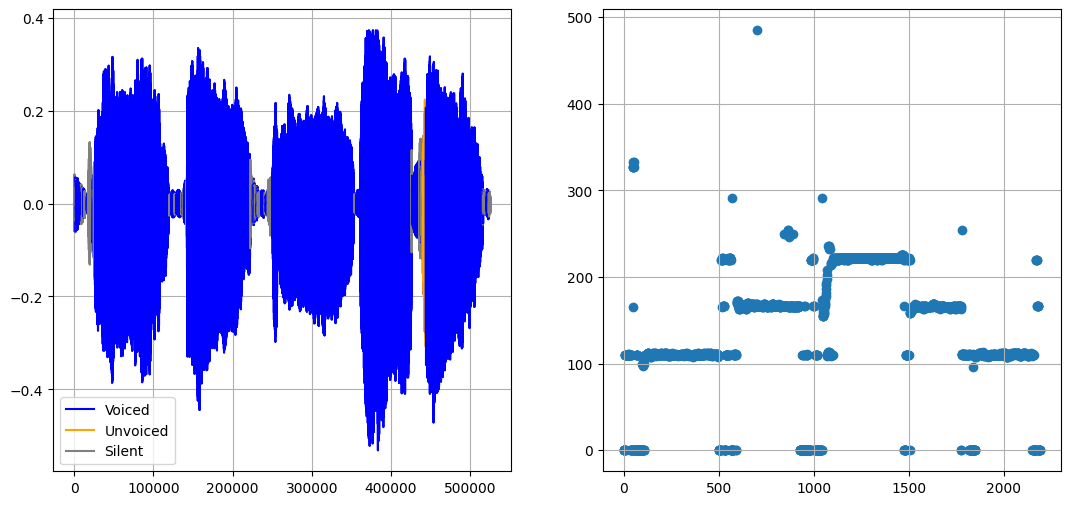

2190it [00:07, 299.33it/s]


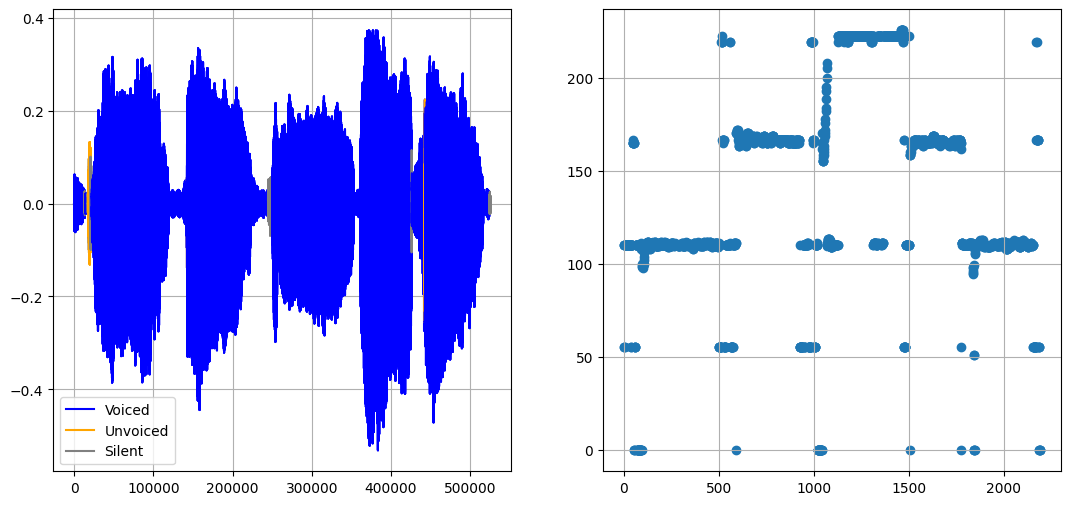

2190it [00:17, 128.68it/s]


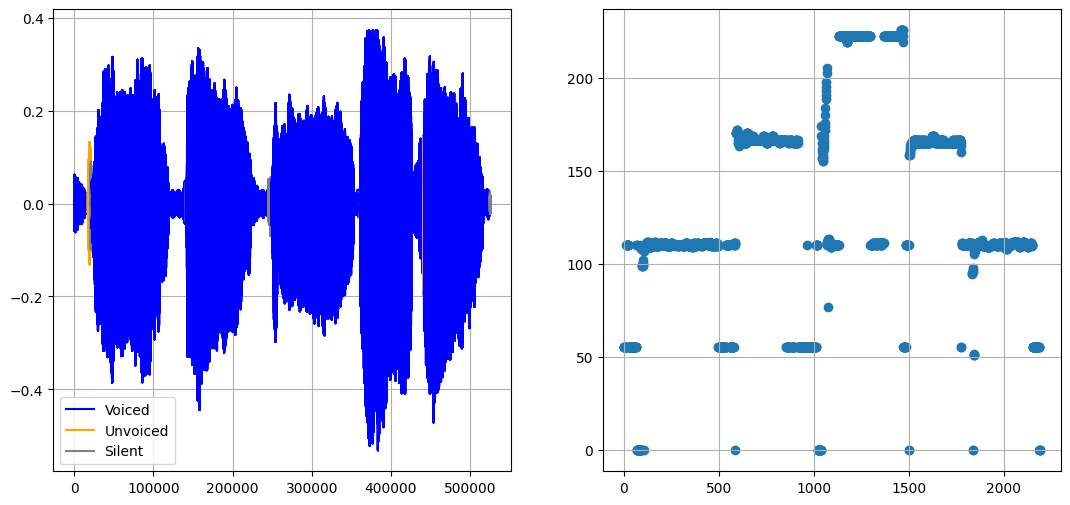

In [19]:

for frameSize in [0.025, 0.05, 0.1]:

    (sig, rate) = sf.read('sa-pa-sa.wav')

    ###########################
    # Chunk the signal into N frames with specific frame size and frameShift and, if required, use a windowing function to reduce the boundary effects.
    ###########################
    frameSize = frameSize
    frameShift = 0.015
    windowing = 'hamming'
    Frames = FrameSig(sig, rate, frameSize, frameShift, windowing)
    EnergyThreshold = 1 #set energy threshold for fricative vs silence frame detection from the unvoiced frames
    PeakThreshold = 0.5
    decision = [0]*len(Frames)
    freq = [0]* len(Frames)


    for index, Frame in tqdm(enumerate(Frames)):


      VoicedDecision, EstimatedF0=VoicedVSUnvoiced(Frame, rate, PeakThreshold)

      if VoicedDecision == 1:

        decision[index] = 1

        freq[index] = EstimatedF0

      else:

        value = SilenceVSUnvoiced(Frame, EnergyThreshold)

        if value == -1:

          decision[index] = -1

        else:
          decision[index] = 0

    frameShift = int(rate * 0.015)
    frameSize = int(rate * frameSize)

    fig, axes = plt.subplots(1, 2, figsize=(13, 6))

    for index, frame in enumerate(Frames):

        if index*frameShift + frameSize >  len(sig):

          axes[0].plot(range(index*frameShift, len(sig)), sig[index*frameShift:], color = color(decision[index]))
          continue

        axes[0].plot(range(index*frameShift, index*frameShift + frameSize), sig[index*frameShift: index*frameShift + frameSize], color = color(decision[index]))

    blue_line = mlines.Line2D([], [], color='blue', label='Voiced')
    orange_line = mlines.Line2D([], [], color='orange', label='Unvoiced')
    grey_line = mlines.Line2D([], [], color='grey', label='Silent')

    axes[0].legend(handles=[blue_line, orange_line, grey_line])
    axes[0].grid()

    frequencies = [get_f0(AutoCorrelation(Frames[i]), rate)[0] for i in range(len(Frames))]

    for index in range(len(frequencies)):

      if decision[index] == 0 or decision[index] == -1:

        frequencies[index] = 0

    axes[1].grid()
    axes[1].scatter(range(len(Frames)),frequencies)

    plt.show()

2190it [00:20, 109.06it/s]


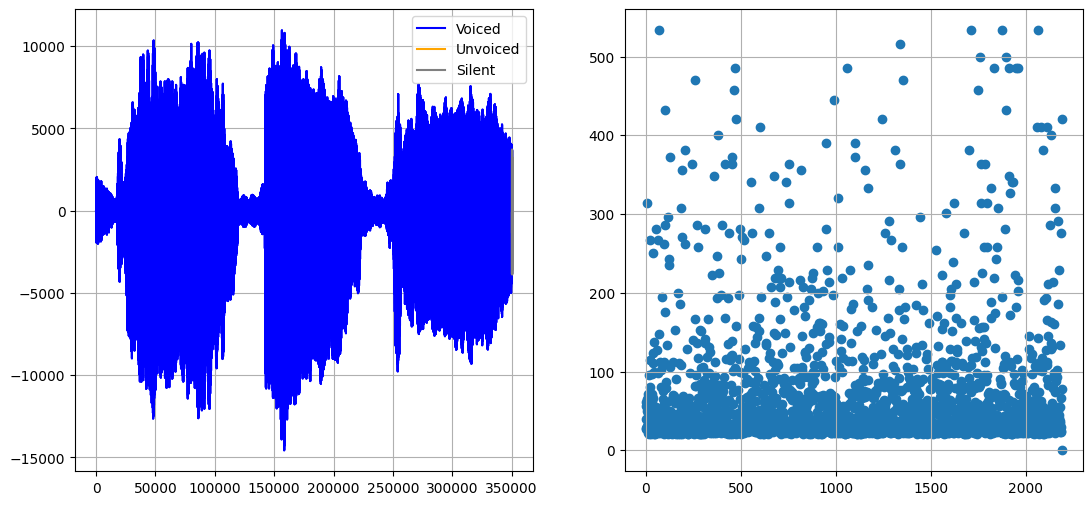

In [16]:
(rate, sig) = scipy.io.wavfile.read('sa-pa-sa.wav')


###########################
# Chunk the signal into N frames with specific frame size and frameShift and, if required, use a windowing function to reduce the boundary effects.
###########################
frameSize = 0.1
frameShift = 0.015
windowing = 'hamming'
Frames = FrameSig(sig, rate, frameSize, frameShift, windowing)
EnergyThreshold = 5 #set energy threshold for fricative vs silence frame detection from the unvoiced frames
PeakThreshold = 0.5
decision = [0]*len(Frames)
freq = [0]* len(Frames)



for index, Frame in tqdm(enumerate(Frames)):


  VoicedDecision, EstimatedF0=VoicedVSUnvoiced(Frame, rate, PeakThreshold)

  if VoicedDecision == 1:

    decision[index] = 1

    freq[index] = EstimatedF0

  else:

    value = SilenceVSUnvoiced(Frame, EnergyThreshold)

    if value == -1:

      decision[index] = -1

    else:
       decision[index] = 0

frameShift = int(rate * 0.010)
frameSize = int(rate * 0.025)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

for index, frame in enumerate(Frames):

    if index*frameShift + frameSize >  len(sig):

      axes[0].plot(range(index*frameShift, len(sig)), sig[index*frameShift:], color = color(decision[index]))
      continue

    axes[0].plot(range(index*frameShift, index*frameShift + frameSize), sig[index*frameShift: index*frameShift + frameSize], color = color(decision[index]))

blue_line = mlines.Line2D([], [], color='blue', label='Voiced')
orange_line = mlines.Line2D([], [], color='orange', label='Unvoiced')
grey_line = mlines.Line2D([], [], color='grey', label='Silent')

axes[0].legend(handles=[blue_line, orange_line, grey_line])
axes[0].grid()

frequencies = [get_f0(AutoCorrelation(Frames[i]), rate)[0] for i in range(len(Frames))]

for index in range(len(frequencies)):

  if decision[index] == 0 or decision[index] == -1:

    frequencies[index] = 0

axes[1].grid()
axes[1].scatter(range(len(Frames)),frequencies)

2190it [00:24, 88.59it/s]


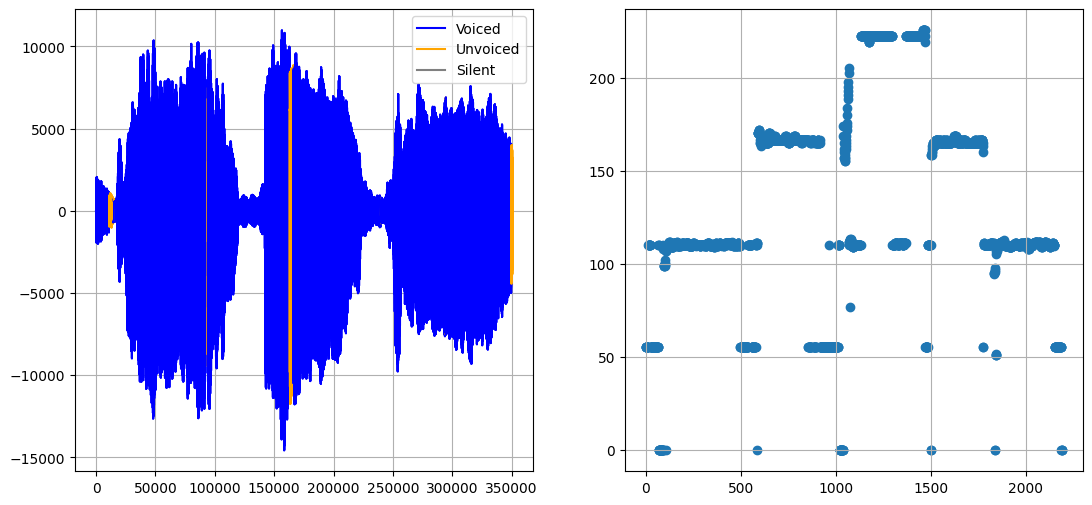

In [17]:
(rate, sig) = scipy.io.wavfile.read('sa-pa-sa.wav')


###########################
# Chunk the signal into N frames with specific frame size and frameShift and, if required, use a windowing function to reduce the boundary effects.
###########################
frameSize = 0.1
frameShift = 0.015
windowing = 'hamming'
sig = sig - np.mean(sig)
Frames = FrameSig(sig, rate, frameSize, frameShift, windowing)
EnergyThreshold = 5 #set energy threshold for fricative vs silence frame detection from the unvoiced frames
PeakThreshold = 0.5
decision = [0]*len(Frames)
freq = [0]* len(Frames)


for index, Frame in tqdm(enumerate(Frames)):


  VoicedDecision, EstimatedF0=VoicedVSUnvoiced(Frame, rate, PeakThreshold)

  if VoicedDecision == 1:

    decision[index] = 1

    freq[index] = EstimatedF0

  else:

    value = SilenceVSUnvoiced(Frame, EnergyThreshold)

    if value == -1:

      decision[index] = -1

    else:
       decision[index] = 0

frameShift = int(rate * 0.010)
frameSize = int(rate * 0.025)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

for index, frame in enumerate(Frames):

    if index*frameShift + frameSize >  len(sig):

      axes[0].plot(range(index*frameShift, len(sig)), sig[index*frameShift:], color = color(decision[index]))
      continue

    axes[0].plot(range(index*frameShift, index*frameShift + frameSize), sig[index*frameShift: index*frameShift + frameSize], color = color(decision[index]))

blue_line = mlines.Line2D([], [], color='blue', label='Voiced')
orange_line = mlines.Line2D([], [], color='orange', label='Unvoiced')
grey_line = mlines.Line2D([], [], color='grey', label='Silent')

axes[0].legend(handles=[blue_line, orange_line, grey_line])
axes[0].grid()

frequencies = [get_f0(AutoCorrelation(Frames[i]), rate)[0] for i in range(len(Frames))]

for index in range(len(frequencies)):

  if decision[index] == 0 or decision[index] == -1:

    frequencies[index] = 0

axes[1].grid()
axes[1].scatter(range(len(Frames)),frequencies)

2190it [00:16, 134.24it/s]


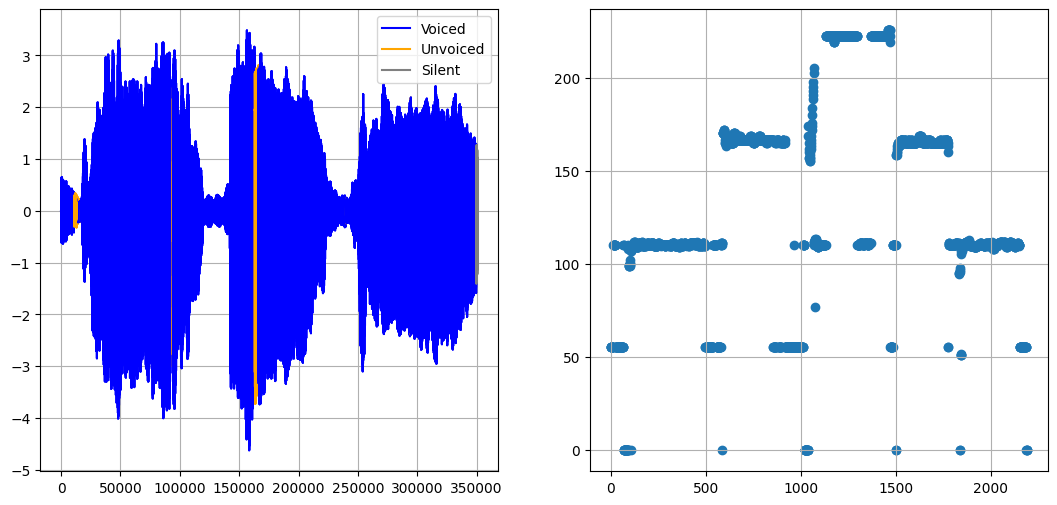

In [18]:
(rate, sig) = scipy.io.wavfile.read('sa-pa-sa.wav')


###########################
# Chunk the signal into N frames with specific frame size and frameShift and, if required, use a windowing function to reduce the boundary effects.
###########################
frameSize = 0.1
frameShift = 0.015
windowing = 'hamming'
sig = (sig - np.mean(sig))/np.sqrt(np.var(sig))
Frames = FrameSig(sig, rate, frameSize, frameShift, windowing)
EnergyThreshold = 5 #set energy threshold for fricative vs silence frame detection from the unvoiced frames
PeakThreshold = 0.5
decision = [0]*len(Frames)
freq = [0]* len(Frames)


for index, Frame in tqdm(enumerate(Frames)):


  VoicedDecision, EstimatedF0=VoicedVSUnvoiced(Frame, rate, PeakThreshold)

  if VoicedDecision == 1:

    decision[index] = 1

    freq[index] = EstimatedF0

  else:

    value = SilenceVSUnvoiced(Frame, EnergyThreshold)

    if value == -1:

      decision[index] = -1

    else:
       decision[index] = 0

frameShift = int(rate * 0.010)
frameSize = int(rate * 0.025)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

for index, frame in enumerate(Frames):

    if index*frameShift + frameSize >  len(sig):

      axes[0].plot(range(index*frameShift, len(sig)), sig[index*frameShift:], color = color(decision[index]))
      continue

    axes[0].plot(range(index*frameShift, index*frameShift + frameSize), sig[index*frameShift: index*frameShift + frameSize], color = color(decision[index]))

blue_line = mlines.Line2D([], [], color='blue', label='Voiced')
orange_line = mlines.Line2D([], [], color='orange', label='Unvoiced')
grey_line = mlines.Line2D([], [], color='grey', label='Silent')

axes[0].legend(handles=[blue_line, orange_line, grey_line])
axes[0].grid()

frequencies = [get_f0(AutoCorrelation(Frames[i]), rate)[0] for i in range(len(Frames))]

for index in range(len(frequencies)):

  if decision[index] == 0 or decision[index] == -1:

    frequencies[index] = 0

axes[1].grid()
axes[1].scatter(range(len(Frames)),frequencies)

<h4>  7) Provide a detailed report of your observations for each experiment. </h4>


<dt> <h4> <b> $\underline{\textbf{OBSERVATIONS}}$: </b> </h4> </dt>
<ul>
<li> Start of by dividing each speech signal into frames, using the FrameSig function (I used size of frame as 0.025 s, frame shift as 0.010 s and windowing technique as 'hamming') which returns a list of frames.
</li>
</ul>
<dt> <h4> <b> <u> Voiced / Unvoiced activity detection: </b> </u> </h4> </dt>
<ul>
<li>Using the AutoCorrelation function get the autocorrelation sequence of the frame.
</li>
<li>
Using the autocorrelation sequence of each frame find the second highest peak and then find fundamental frequency of the frame.
<ol>
<li> Find all peaks in the sequence (Rxx: autocorrelation sequence) , a point with index k is called a peak if: <br>
  <b> Rxx[k] > Rxx[k-i] and Rxx[k] > Rxx[k+i] for i in [1,30]</b>
</li>
<li>
Take the highest value of peaks if list of peaks is not empty as the second highest peak (since Rxx[0] is always the first highest peak)
</li>
<li>
Using this location compute F0.
</li>
</ol>
</li>
<li>Next I used a threshold and compared the second peak value with it. And classified each for the frames as voiced and unvoiced.Voiced are expected to have more amplitude than Unvoiced, can be seen from the plot that, voiced regions are those of high amplitude than unvoiced.
</li>
</ul>
 <br>
<dt> <h4> <b> <u> Unvoiced / Silent Classification </b> </u></h4> </dt>
</ul>
<b><u>Observation</u></b>:
<ul>
<li>
After classifying the signal frames as voiced and unvoiced, next step is to classify unvoiced regions into silent and non-silent.
</li>
<li>
This classification is based on the energy, where the non-silent unvoiced have more energy than that of silent. We set a threshold and say if energy of the frame is more than given threshold it is non-silent else silent.
</li>
<li>
 We can see in the plot that, we have silent and unvoiced at low amplitudes, but also at the same time, we have silent where the energy is less.
 </li>
 <li>
 The threshold is a hyperparameter, that must be tuned based on the signal. Can be decided looking at the energy vs frame plot and locating the silent regions.
 </li>

</ul>
<h4>
1) Examine how frame size impacts voice activity detection and fundamental frequency estimation. Try using different frame sizes and observe how they affect the quality of the tags.
</h4>
<br>
A)Clearly looking at the plots we can say quality of tags decreases as frame size increases. Larger frame sizes (e.g., 50-100 milliseconds) smooth out rapid changes, resulting in lower temporal resolution. This can cause important details to be missed or blurred, leading to less precise tagging of voiced/unvoiced segments.


<h4> <b> <u> 2) Effect of preprocessing: </u> </b> </h4>
<br>
Simple preprocessing has moderate effect on the signal as seen by plots. mean subtraction is done to adjust the amplitude of the signal to a standard level, ensuring consistency across different recordings.
<br>
<h4> <b> <u> 4) Why Does the Autocorrelation Function Roll Off with Lag?</u> </b> </h4>
<br>
<ul>
<li>
During computation of the autocorrelation for a discrete signal of finite length, with increase in lag, the overlap between samples decreases resulting in a roll-off.
</li>
<li>
For example, with a lag of k = 0, all samples are used in the calculation. As the lag increases to k = 1, the first sample no longer has a counterpart to correlate with, as k increases the samples are lesser which naturally causes the computed autocorrelation value to decrease, resulting in a roll-off.
</li>
</ul>
Methods to prevent roll-off:
<ul>
<li>
Normalize the autocorrelation function, for example: <br>
<center> $R_{xx}$[k] = $\frac{1}{r_{xx}[0]}\sum_{n=0}^{N}$ x[n]x[n+k]
$\;\;\;\;$ k = ...,-2,-1,0,1,2,... </center>
</li>
</ul>




<b><u>Conclusion:</u></b><br>